In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, TimeDistributed, Bidirectional, LSTM, Dense
import tensorflow as tf

# 加载前面训练好的模型，精度为73%
pretrained_resnet18_model = tf.keras.models.load_model("Weights/CNNBiLSTM_image_resnet182d_46.h5")
resnet18_feature_extractor = Model(inputs=pretrained_resnet18_model.input, 
                                   outputs=pretrained_resnet18_model.layers[-2].output)
# 将特征提取器的所有层设置为不可训练的
for layer in resnet18_feature_extractor.layers:
    layer.trainable = False

time_steps, height, width, channels = 10, 50, 50, 3
input_shape = (time_steps, height, width, channels)
inputs = Input(shape=input_shape)
x = TimeDistributed(resnet18_feature_extractor)(inputs)
x = Bidirectional(LSTM(units=256, return_sequences=False))(x)
outputs = Dense(6, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

2024-01-05 01:05:05.646252: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-05 01:05:05.709660: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-05 01:05:06.736008: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-01-05 01:05:08.283159: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22288 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:31:00.0, compute cap

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 50, 50, 3)]   0         
                                                                 
 time_distributed (TimeDist  (None, 10, 512)           11190464  
 ributed)                                                        
                                                                 
 bidirectional (Bidirection  (None, 512)               1574912   
 al)                                                             
                                                                 
 dense (Dense)               (None, 6)                 3078      
                                                                 
Total params: 12768454 (48.71 MB)
Trainable params: 1577990 (6.02 MB)
Non-trainable params: 11190464 (42.69 MB)
_________________________________________________________________


In [2]:
import numpy as np
x_train = np.load('VideoFramePickle/x_train.npy')
y_train = np.load('VideoFramePickle/y_train.npy')

In [3]:
from keras.callbacks import ModelCheckpoint
# 配置模型检查点
checkpoint = ModelCheckpoint(
    'temp/CNNBiLSTM_image_resnet182d_multiplex_epoch_{epoch:02d}.h5',  # 文件路径，其中{epoch:02d}是格式化字符串，用于在文件名中包含epoch编号
    monitor='val_accuracy',            # 可以是'val_loss', 'val_accuracy', 'loss', 'accuracy'等
    verbose=1,                        # 日志显示模式，0或1
    save_best_only=False,             # 如果设置为True，则只保存在验证集上性能最好的模型
    save_weights_only=False,          # 如果设置为True，则只保存模型的权重，如果为False，则保存整个模型
    mode='auto',                      # 可以是'auto', 'min', 'max'，决定了监控指标是应该最大化还是最小化
    save_freq='epoch'                 # 检查点之间的间隔（每个epoch）
)
history = model.fit(
    x_train, y_train, 
    epochs=30, 
    batch_size=15, 
    # validation_data=(x_val, y_val),
    validation_split=0.3,
    callbacks=[checkpoint],
    verbose=1,
    workers=128,
    shuffle=True
)

Epoch 1/30


2024-01-05 01:05:59.454637: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-01-05 01:05:59.715502: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-01-05 01:06:00.102814: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7aa9330 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-05 01:06:00.102850: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-01-05 01:06:00.109737: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-05 01:06:00.254927: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the proces

2391/2391 [==============================] - ETA: 0s - loss: 0.6582 - accuracy: 0.7788
Epoch 1: saving model to temp/CNNBiLSTM_image_resnet182d_multiplex_epoch_01.h5


/root/miniconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2391/2391 [==============================] - 75s 29ms/step - loss: 0.6582 - accuracy: 0.7788 - val_loss: 0.6240 - val_accuracy: 0.7857
Epoch 2/30
2391/2391 [==============================] - ETA: 0s - loss: 0.6173 - accuracy: 0.7905
Epoch 2: saving model to temp/CNNBiLSTM_image_resnet182d_multiplex_epoch_02.h5
2391/2391 [==============================] - 54s 22ms/step - loss: 0.6173 - accuracy: 0.7905 - val_loss: 0.6106 - val_accuracy: 0.7940
Epoch 3/30
2390/2391 [============================>.] - ETA: 0s - loss: 0.6035 - accuracy: 0.7944
Epoch 3: saving model to temp/CNNBiLSTM_image_resnet182d_multiplex_epoch_03.h5
2391/2391 [==============================] - 58s 24ms/step - loss: 0.6035 - accuracy: 0.7944 - val_loss: 0.5815 - val_accuracy: 0.7981
Epoch 4/30
2390/2391 [============================>.] - ETA: 0s - loss: 0.5926 - accuracy: 0.7977
Epoch 4: saving model to temp/CNNBiLSTM_image_resnet182d_multiplex_epoch_04.h5
2391/2391 [==============================] - 58s 24ms/step - los

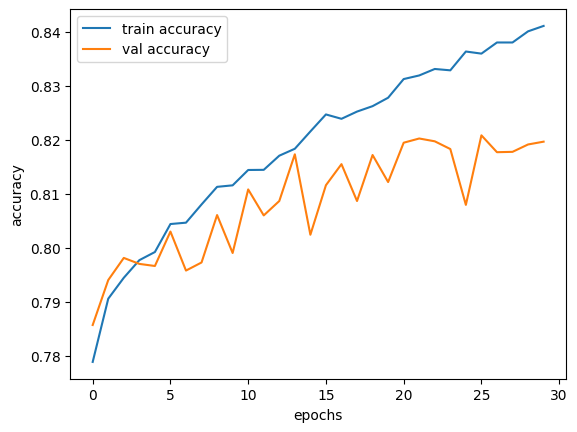

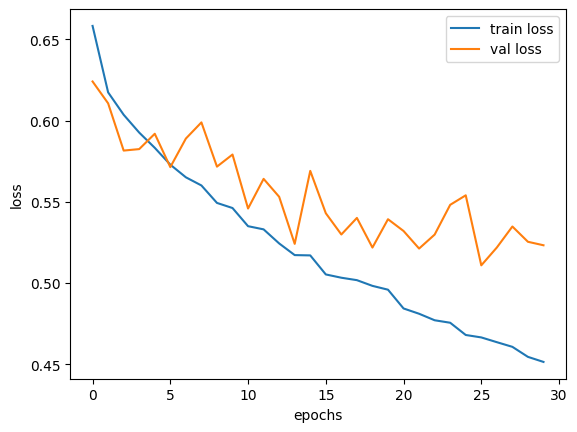

In [4]:
from CNNBiLSTM_LoadData import draw_history
draw_history(history,30)

In [5]:
import numpy as np
model=tf.keras.models.load_model("temp/CNNBiLSTM_image_resnet182d_multiplex_epoch_26.h5")
x_test = np.load('VideoFramePickle/x_test.npy')
y_test = np.load('VideoFramePickle/y_test.npy')
loss,acc = model.evaluate(x_test,y_test)
print(f"loss {loss},acc {acc}")

178/178 [==============================] - 4s 14ms/step - loss: 0.5141 - accuracy: 0.8221
loss 0.5140972137451172,acc 0.8220621943473816
